In [1]:
require(ggplot2)
require(data.table)
require(Hmisc)
require(ggthemes)
require(gridExtra)
require(grid)
require(lattice)
require(scales)
require(RColorBrewer)
require(reshape)

Loading required package: ggplot2
Loading required package: data.table
Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: ggthemes
Loading required package: gridExtra
Loading required package: grid
Loading required package: scales
Loading required package: RColorBrewer
Loading required package: reshape

Attaching package: ‘reshape’

The following object is masked from ‘package:data.table’:

    melt



In [2]:
# install.packages('bit64')

In [3]:
directory = "/mnt/sdb1/baseerat/numerical-evals/12-11-2017/logs-1M"
blues = brewer.pal(n = 6, "Blues")[4:6]
bluesLong = brewer.pal(n = 6, "Blues")[2:6]
plotTheme <- theme_hc() + theme(legend.title=element_blank(), 
                                legend.position="top", 
                                text=element_text(size=14),
                                panel.spacing.y=unit(1.5, "lines"))

In [4]:
blues

[1] "#6BAED6" "#3182BD" "#08519C"

In [5]:
groupSizePerGroupPerTenant <- fread(paste(directory, "group_size_per_group_per_tenant.csv", sep="/"), sep=",", 
                                    header=TRUE)
groupSizePerGroupPerTenant[groupSizeDist == "wve"]$groupSizeDist <- "WVE"
groupSizePerGroupPerTenant[groupSizeDist == "uniform"]$groupSizeDist <- "Uniform"

In [12]:
plt <- ggplot(groupSizePerGroupPerTenant) +
   stat_ecdf(aes(x=groupSize, color="something"), size=0.7) +
   facet_grid(. ~ groupSizeDist) +
   ggtitle("") +
   xlab("Group Size Distributions") +
   ylab("ECDF") +
   scale_color_manual(values=blues) +
   plotTheme + theme(text=element_text(size=11), axis.text.x = element_text(angle = 45, hjust = 1),                                 
                     legend.position="none")
ggsave(plt, file="group_size_per_group_per_tenant.pdf", height=2, width=5)

In [46]:
head(groupSizePerGroupPerTenant[groupSizeDist == "wve", quantile(groupSize,c(0.5,0.75,0.99))])

50% 75% 99% 
 NA  NA  NA

In [47]:
replaceFactors <- function(dt) {
    dt <- dt[placementNumHostsPerLeaf %in% c('uniform', '12')]
    dt[placementNumHostsPerLeaf == '12']$placementNumHostsPerLeaf <- "P=12"
    dt[placementNumHostsPerLeaf == 'uniform']$placementNumHostsPerLeaf <- "P=1"
    dt[groupSizeDist == "wve"]$groupSizeDist <- "WVE"
    dt[groupSizeDist == "uniform"]$groupSizeDist <- "Uniform"
    if("podsAlgorithm" %in% colnames(dt)) {
       dt <- dt[podsAlgorithm != "exact-match" & podsRedundancyPerBitmap <= 12 & podsNumBitmaps != 3]
    }
    if ("leafsAlgorithm" %in% colnames(dt)) {
       dt <- dt[leafsAlgorithm != "exact-match" & leafsRedundancyPerBitmap <= 12  & leafsNumBitmaps != 20]
    }
    return(dt)
}

rulesLabeller <- function(rules) {
    paste("F: ", rules, sep="")
}

format_si <- function(...) {
  # Format a vector of numeric values according
  # to the International System of Units.
  # http://en.wikipedia.org/wiki/SI_prefix
  #
  # Based on code by Ben Tupper
  # https://stat.ethz.ch/pipermail/r-help/2012-January/299804.html
  # Args:
  #   ...: Args passed to format()
  #
  # Returns:
  #   A function to format a vector of strings using
  #   SI prefix notation
  #
  
  function(x) {
    limits <- c(1e-24, 1e-21, 1e-18, 1e-15, 1e-12,
                1e-9,  1e-6,  1e-3,  1e0,   1e3,
                1e6,   1e9,   1e12,  1e15,  1e18,
                1e21,  1e24)
    prefix <- c("y",   "z",   "a",   "f",   "p",
                "n",   "µ",   "m",   " ",   "K",
                "M",   "G",   "T",   "P",   "E",
                "Z",   "Y")
  
    # Vector with array indices according to position in intervals
    i <- findInterval(abs(x), limits)
  
    # Set prefix to " " for very small values < 1e-24
    i <- ifelse(i==0, which(limits == 1e0), i)

    paste(format(round(x/limits[i], 1),
                 trim=TRUE, scientific=FALSE, ...),
          prefix[i], sep="")
  }
}

In [48]:
groupsCoveredWithBitmapsOnlyForPods <- replaceFactors(fread(paste(directory, 
                                                   "groups_covered_with_bitmaps_only_for_pods.csv", sep="/"), sep=",", 
                                             header=TRUE))


In [49]:
head(groupsCoveredWithBitmapsOnlyForPods)

,groupsCovered,groupsCoveredWithoutDefaultBitmap,groupSizeDist,placementDist,placementNumHostsPerLeaf,seed,podsAlgorithm,podsNumBitmaps,podsNumNodesPerBitmap,podsRedundancyPerBitmap,podsNumRules
1,977071,977071,Uniform,colocate-colocate-uniform,P=12,0,random-fuzzy-match,1,3,0,10000
2,977071,977071,Uniform,colocate-colocate-uniform,P=12,0,random-fuzzy-match,1,3,0,64000
3,978869,978869,Uniform,colocate-colocate-uniform,P=12,0,random-fuzzy-match,1,3,12,10000
4,978869,978869,Uniform,colocate-colocate-uniform,P=12,0,random-fuzzy-match,1,3,12,64000
5,977473,977473,Uniform,colocate-colocate-uniform,P=12,0,random-fuzzy-match,1,3,6,10000
6,992172,992172,Uniform,colocate-colocate-uniform,P=12,0,random-fuzzy-match,2,3,0,10000


In [59]:
p1 <- ggplot(groupsCoveredWithBitmapsOnlyForPods[podsNumRules == 10000], aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(podsNumBitmaps), 
                fill=interaction(podsRedundancyPerBitmap))) +
   stat_summary(fun.data=mean_sdl, geom="bar",position=position_dodge(width=0.8), width=0.8, col="black") +
   stat_summary(fun.data=mean_sdl, geom="errorbar",position=position_dodge(width=0.8), width=0.2) +
   facet_grid(factor(placementNumHostsPerLeaf) ~ groupSizeDist) +
   xlab("Number of pod p-rules") +
   ylab("Groups covered with p-rules") +
   scale_fill_manual(values=blues, name="Redundancy") +
   plotTheme + theme(legend.title=element_text(size=12)) +
   scale_y_continuous(labels=format_si())
ggsave(p1, file="groups_covered_with_bitmaps_only_for_pods.pdf",  height=4.5, width=4)

In [60]:
groupsCoveredWithBitmapsOnlyForLeafs <- replaceFactors(fread(paste(directory, 
                                                   "groups_covered_with_bitmaps_only_for_leafs.csv", sep="/"), sep=",", 
                                             header=TRUE))

In [61]:
p2 <- ggplot(groupsCoveredWithBitmapsOnlyForLeafs[leafsNumRules == 10000], 
             aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(leafsNumBitmaps), 
                fill=interaction(leafsRedundancyPerBitmap))) +
   stat_summary(fun.data=mean_sdl, geom="bar",position=position_dodge(width=0.8), width=0.8, col="black") +
   stat_summary(fun.data=mean_sdl, geom="errorbar",position=position_dodge(width=0.8), width=0.2) +
   facet_grid(factor(placementNumHostsPerLeaf) ~ groupSizeDist) +
   xlab("Number of leaf p-rules") +
   ylab("Groups covered  with p-rules") +
   scale_fill_manual(values=blues, name="Redundancy") +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.title=element_text(size=12))
ggsave(p2, file="groups_covered_with_bitmaps_only_for_leafs.pdf",  height=4.5, width=4)

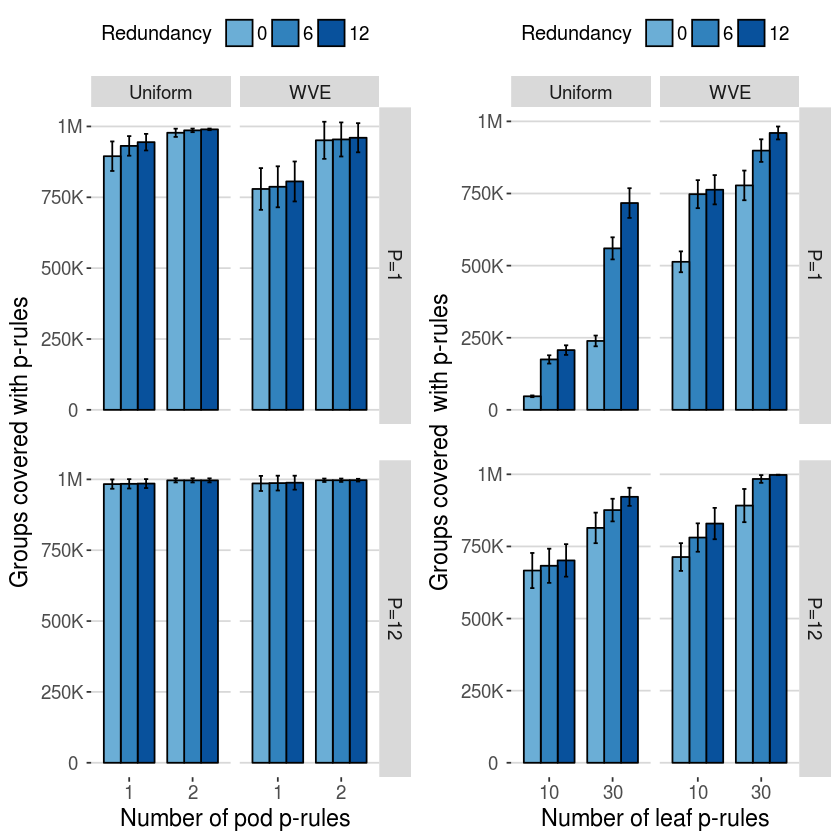

In [62]:
combined <- grid.arrange(p1, p2, ncol=2)
ggsave(combined, height=3.5, width=8, file="groups_covered_with_bitmaps_only_all.pdf")

In [114]:
mean(groupsCoveredWithBitmapsOnlyForLeafs[leafsNumRules == 10000 & leafsNumBitmaps == 30 & 
                                     placementNumHostsPerLeaf == "P=1" & groupSizeDist == "WVE" &
                                    leafsRedundancyPerBitmap == 12]$groupsCoveredWithoutDefaultBitmap)

[1] 959825

In [54]:
ruleCountForPods <- replaceFactors(fread(paste(directory, "rule_count_for_pods.csv", sep="/"), sep=",", header=TRUE))

In [55]:
plt <- ggplot(ruleCountForPods) +
    geom_boxplot(aes(y=numRules, x=factor(podsNumBitmaps), 
                     fill=interaction(podsRedundancyPerBitmap)),
                 outlier.size=0.5) +
    facet_grid(factor(placementNumHostsPerLeaf)~ groupSizeDist * podsNumRules, 
               labeller = labeller(podsNumRules = rulesLabeller)) +
    xlab("Number of p-rules") +
    ylab("Number of s-rules") +
    scale_fill_manual(values=blues, name="Redundancy") +
    scale_y_continuous(labels=format_si()) +
    plotTheme + theme(legend.title=element_text(size=12))
ggsave(plt, file="rule_count_for_pods.pdf",  height=3.5, width=7)

In [134]:
max(ruleCountForPods[podsNumRules == 64000 & podsNumBitmaps == 2 & 
                                     placementNumHostsPerLeaf == "P=1" & groupSizeDist == "WVE" &
                                    podsRedundancyPerBitmap == 12]$numRules)

[1] 11871

In [57]:
ruleCountForLeafs <- replaceFactors(fread(paste(directory, "rule_count_for_leafs.csv", sep="/"), sep=",", header=TRUE))

In [58]:
plt <- ggplot(ruleCountForLeafs) +
    geom_boxplot(aes(y=numRules, x=factor(leafsNumBitmaps), 
                     fill=interaction(leafsRedundancyPerBitmap)),
                 outlier.size=0.5) +
    facet_grid(factor(placementNumHostsPerLeaf) ~ groupSizeDist * leafsNumRules, 
               labeller = labeller(leafsNumRules = rulesLabeller)) +
    xlab("Number of p-rules") +
    ylab("Number of s-rules") +
    scale_fill_manual(values=blues, name="Redundancy") +
    scale_y_continuous(labels=format_si()) +
    plotTheme + theme(legend.title=element_text(size=12))
ggsave(plt, file="rule_count_for_leafs.pdf", height=3.5, width=7)

In [135]:
max(ruleCountForLeafs[leafsNumRules == 10000 & leafsNumBitmaps == 30 & 
                                     placementNumHostsPerLeaf == "P=1" & groupSizeDist == "WVE" &
                                    leafsRedundancyPerBitmap == 12]$numRules)

[1] 2907

In [ ]:
########### Trimmed plots

In [150]:
p1 <- ggplot(groupsCoveredWithBitmapsOnlyForLeafs[leafsNumRules == 10000 & 
                                                 placementNumHostsPerLeaf == "P=12" &
                                                 leafsNumBitmaps == 30 &
                                                 groupSizeDist == "WVE"], 
             aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(leafsRedundancyPerBitmap), 
                fill="all")) +
   stat_summary(fun.data=mean_sdl, geom="bar",position=position_dodge(width=0.8), width=0.8, col="black") +
   stat_summary(fun.data=mean_sdl, geom="errorbar",position=position_dodge(width=0.8), width=0.2) +
   xlab("p-rule sharing redundancy (R)") +
   ylab("Groups covered  with p-rules") +
   scale_fill_manual(values=blues, name="Redundancy") +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.position="none")
ggsave(p1, file="groups_covered_with_bitmaps_only_for_leafs_trimmed.pdf",  height=4.5, width=4)

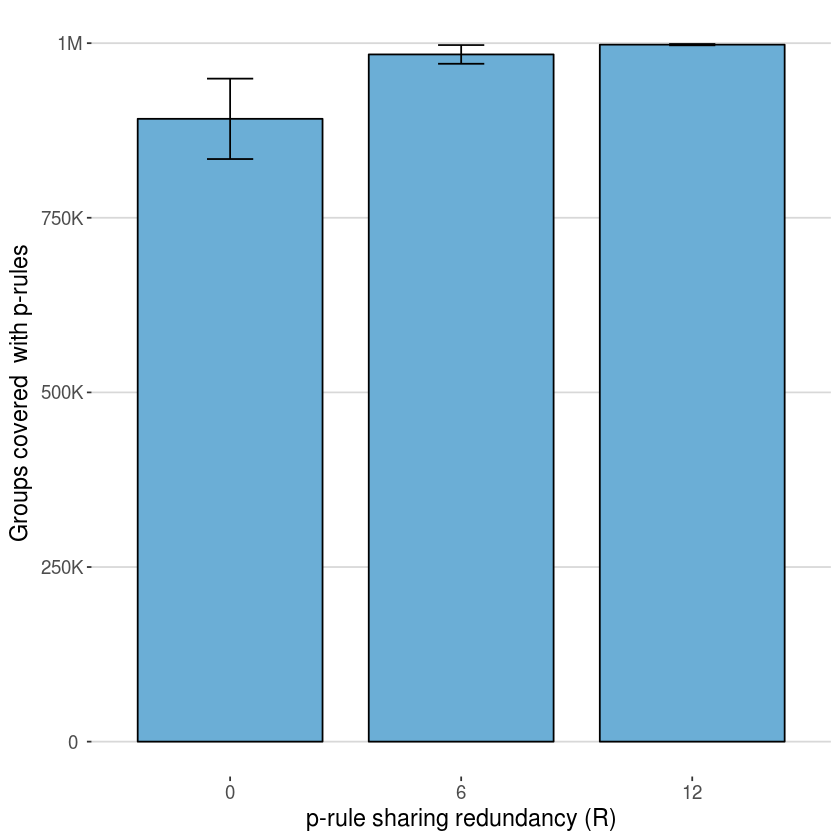

In [151]:
p1

In [189]:
plt <- ggplot(ruleCountForLeafs[leafsNumRules == 64000 & 
                                 placementNumHostsPerLeaf == "P=12" &
                                 leafsNumBitmaps == 30 &
                                 groupSizeDist == "WVE"],
             aes(y=numRules, x=factor(leafsRedundancyPerBitmap), fill="blue")) +
    stat_boxplot(geom ='errorbar', width=0.5) +
    geom_boxplot(outlier.shape=NA) +
    xlab("p-rule sharing redundancy (R)") +
    ylab("Number of s-rules") +
    scale_fill_manual(values=blues, name="Redundancy") +
    scale_y_continuous(limit=c(0, 4000), labels=format_si()) +
    plotTheme + theme(legend.position="none")
ggsave(plt, file="rule_count_for_leafs_trimmed.pdf", height=3.5, width=7)

Warning message:
“Removed 89 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 89 rows containing non-finite values (stat_boxplot).”

Warning message:
“Removed 89 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 89 rows containing non-finite values (stat_boxplot).”

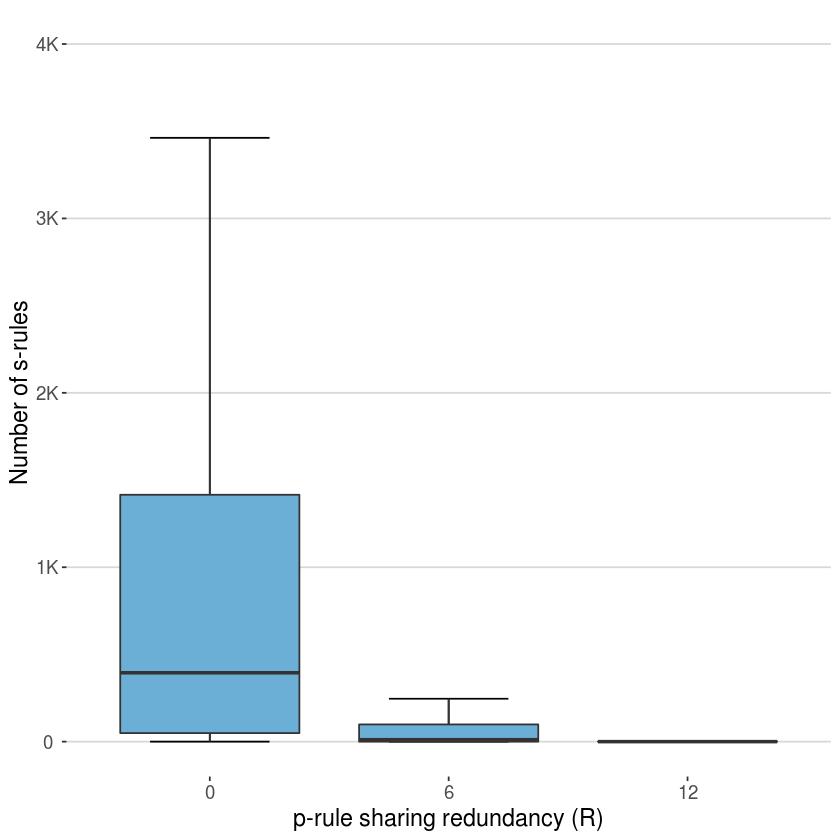

In [190]:
plt

In [20]:
trafficPerGroupPerTenant <- replaceFactors(fread(paste(directory, "traffic_per_group_per_tenant_corrected.csv", sep="/"), sep=",", 
                                  header=TRUE))
trafficPerGroupPerTenant$unicastTraffic <- as.numeric(trafficPerGroupPerTenant$unicastTraffic)
trafficPerGroupPerTenant$multicastTraffic <- as.numeric(trafficPerGroupPerTenant$multicastTraffic)
trafficPerGroupPerTenant$baseeratTraffic <- as.numeric(trafficPerGroupPerTenant$baseeratTraffic)
trafficPerGroupPerTenant$overlayTraffic <- as.numeric(trafficPerGroupPerTenant$overlayTraffic)
trafficPerGroupPerTenant$overlayTrafficCorrected <- as.numeric(trafficPerGroupPerTenant$overlayTrafficCorrected)

In [136]:
trafficMelted <- melt(trafficPerGroupPerTenant, id=c("groupSizeDist", "placementDist", "placementNumHostsPerLeaf", "seed",
                                    "podsAlgorithm", "podsNumBitmaps", "podsNumNodesPerBitmap",
                                    "podsRedundancyPerBitmap", "podsNumRules", "leafsAlgorithm",
                                    "leafsNumBitmaps", "leafsNumNodesPerBitmap", "leafsRedundancyPerBitmap",
                                    "leafsNumRules", "multicastTraffic"))
trafficMelted <- trafficMelted[!(variable == "unicastTraffic" & leafsRedundancyPerBitmap > 0)]
trafficMelted <- trafficMelted[!(variable == "overlayTraffic")]
trafficMelted <- trafficMelted[!(variable == "overlayTrafficCorrected" & leafsRedundancyPerBitmap > 0)]
trafficMelted[variable == "baseeratTraffic"]$variable <- "Baseerat"
trafficMelted$redundancyAndAlgo <- interaction(trafficMelted$variable, 
                                               trafficMelted$leafsRedundancyPerBitmap, sep=":R=")
trafficMelted[redundancyAndAlgo == "unicastTraffic:R=0"]$redundancyAndAlgo <- "Unicast"
trafficMelted[redundancyAndAlgo == "overlayTrafficCorrected:R=0"]$redundancyAndAlgo <- "Overlay Multicast"


In [137]:
range(trafficMelted[redundancyAndAlgo == "Overlay Multicast" & leafsNumBitmaps == 30, value/multicastTraffic])

[1] 1.88732 1.99081

In [166]:
moreColors <- c('beige', 'orange3', '#6BAED6', '#3182BD', '#08519C')

In [167]:
plt <- ggplot(trafficMelted, 
       aes(y=value/multicastTraffic, x=factor(leafsNumBitmaps), 
           fill=factor(redundancyAndAlgo, 
                       levels=c("Unicast", "Overlay Multicast", "Baseerat:R=0", "Baseerat:R=6", "Baseerat:R=12", "Baseerat:R=24", 
                                "Baseerat:R=48")))) +
    stat_summary(fun.data = mean_sdl, geom = "bar", position=position_dodge(0.8), width=0.8, col="black") +
    stat_summary(fun.data = mean_sdl, geom = "errorbar", position=position_dodge(0.8), width=0.2) +
    facet_grid(factor(placementNumHostsPerLeaf) ~ groupSizeDist * leafsNumRules, 
               labeller = labeller(leafsNumRules = rulesLabeller)) +
    xlab("Number of p-rules") +
    ylab("Traffic Overhead\n(ratio with ideal multicast)") +
    scale_fill_manual(values=moreColors, name="Algorithm") +
# scale_fill_brewer(palette="OrRd", name="Algorithm") +
   scale_y_continuous(labels=format_si()) +
   plotTheme + theme(legend.title=element_text(size=12))
ggsave(plt, file="all_traffic_overhead_per_group_per_tenant.pdf", height=3.5, width=7)

In [101]:
plt <- ggplot(trafficPerGroupPerTenant, 
       aes(y=unicastTraffic/multicastTraffic, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 6)) +
    xlab("Number of p-rules") +
    ylab("Unicast-to-Multicast Traffic Overhead") +
    plotTheme
ggsave(plt, file="unicast_traffic_overhead_per_group_per_tenant.pdf", height=5, width=7)

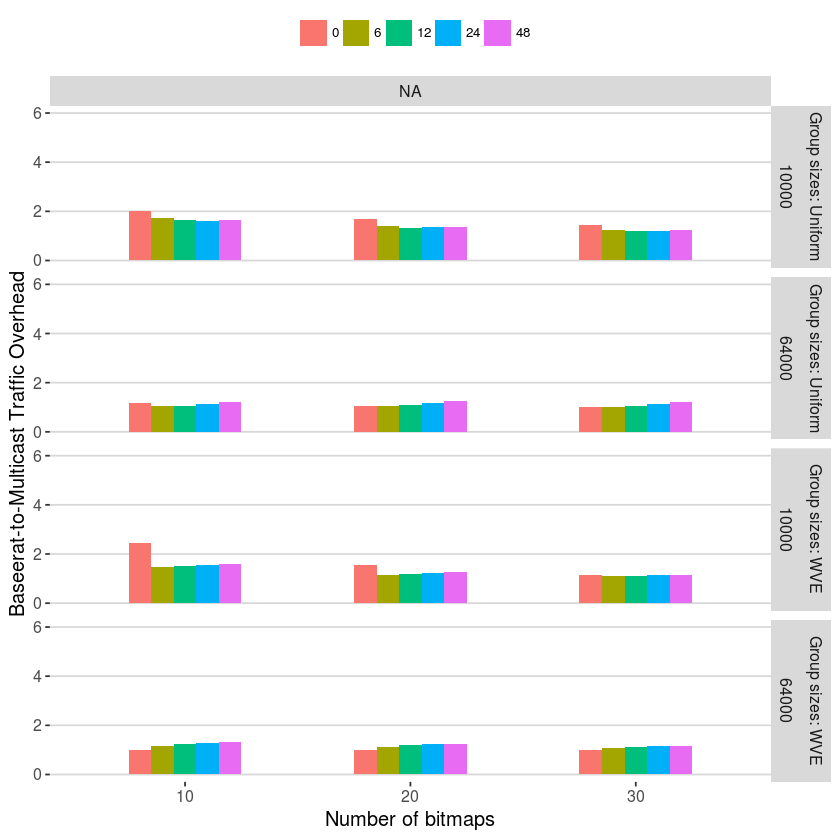

In [295]:
plt <- ggplot(trafficPerGroupPerTenant, 
       aes(y=baseeratTraffic/multicastTraffic, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 6)) +
    xlab("Number of p-rules") +
    ylab("Baseerat-to-Multicast Traffic Overhead") +
    plotTheme
ggsave(plt, file="baseerat_traffic_overhead_per_group_per_tenant.pdf", height=5, width=7)

In [251]:
plt <- ggplot(trafficPerGroupPerTenant, 
       aes(y=overlayTraffic/multicastTraffic, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 6)) +
    xlab("Number of p-rules") +
    ylab("Overlay-to-Multicast Traffic Overhead") +
    plotTheme
ggsave(plt, file="overlay_traffic_overhead_per_group_per_tenant.pdf", height=5, width=7)

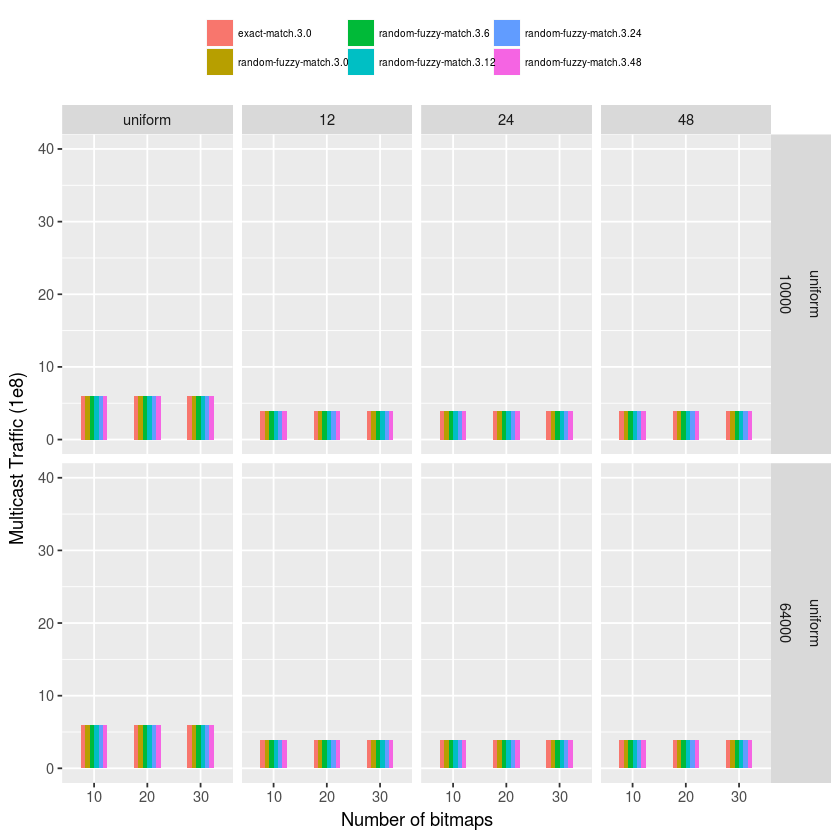

In [24]:
ggplot(trafficPerGroupPerTenant[groupSizeDist == "uniform"], 
       aes(y=multicastTraffic/1e8, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 40)) +
    xlab("Number of p-rules") +
    ylab("Multicast Traffic (1e8)") +
    plotTheme

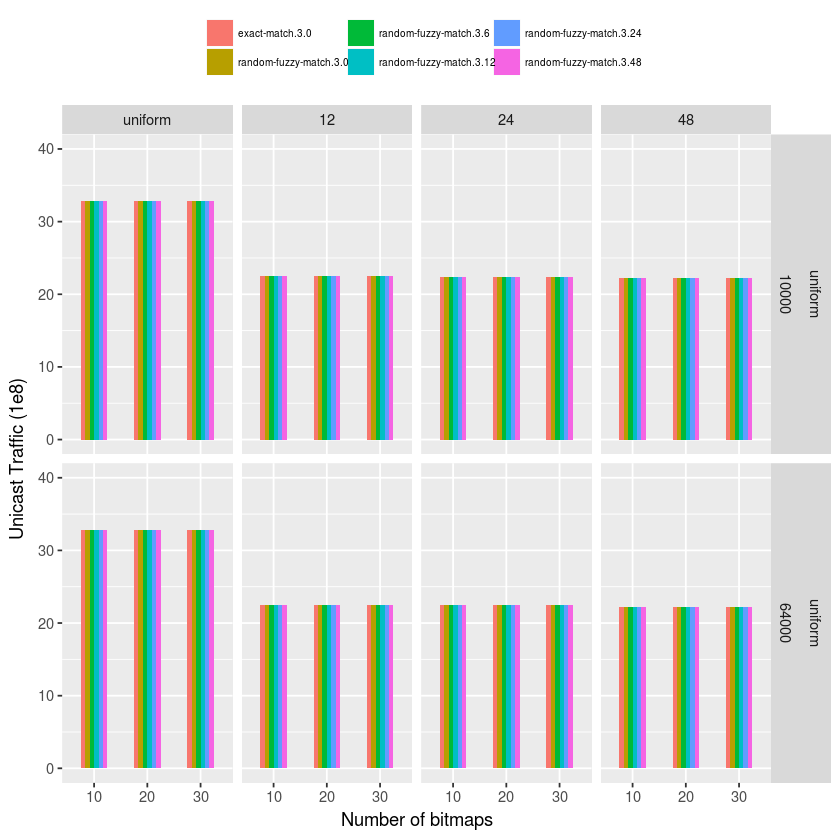

In [25]:
ggplot(trafficPerGroupPerTenant[groupSizeDist == "uniform"], 
       aes(y=unicastTraffic/1e8, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 40)) +
    xlab("Number of p-rules") +
    ylab("Unicast Traffic (1e8)") +
    plotTheme

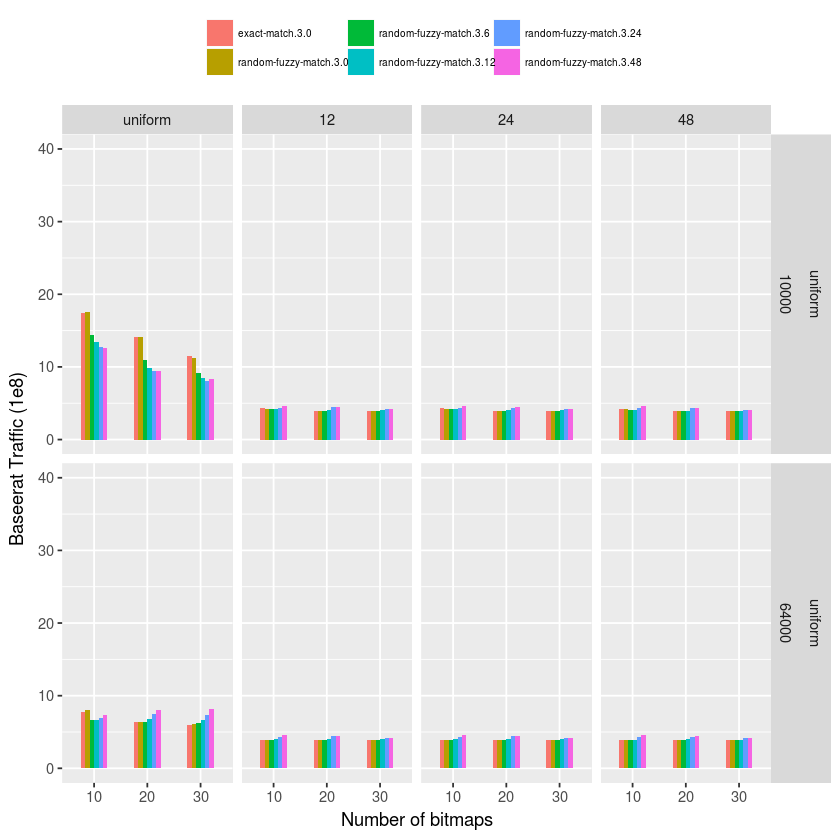

In [26]:
ggplot(trafficPerGroupPerTenant[groupSizeDist == "uniform"], 
       aes(y=baseeratTraffic/1e8, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 40)) +
    xlab("Number of p-rules") +
    ylab("Baseerat Traffic (1e8)") +
    plotTheme

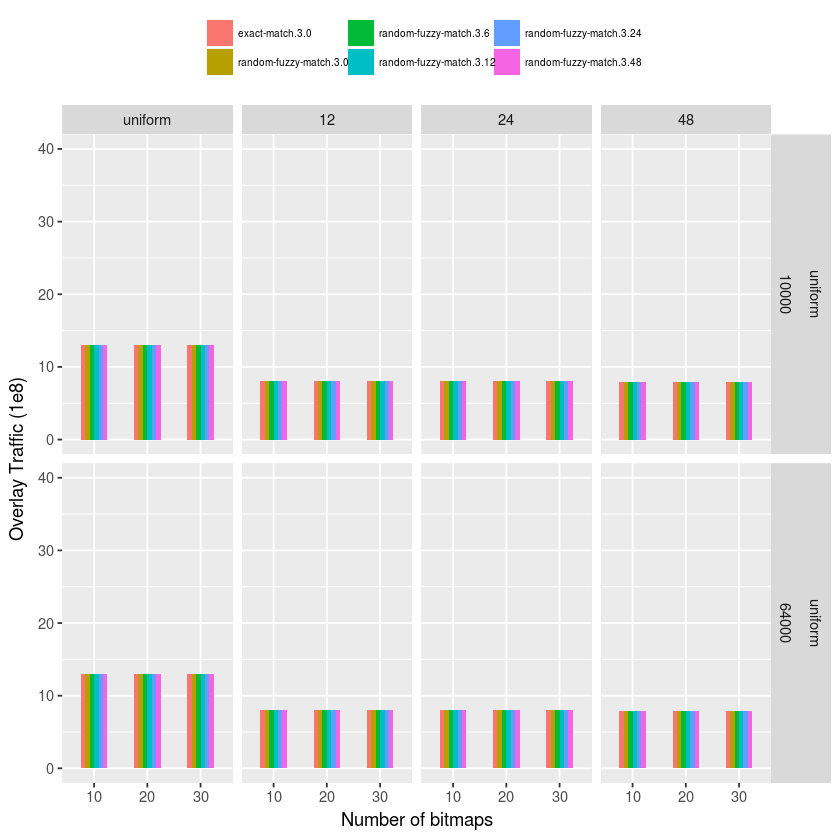

In [27]:
ggplot(trafficPerGroupPerTenant[groupSizeDist == "uniform"], 
       aes(y=overlayTraffic/1e8, x=factor(leafsNumBitmaps), 
           fill=interaction(leafsAlgorithm, leafsNumNodesPerBitmap, leafsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * leafsNumRules ~ factor(placementNumHostsPerLeaf, 
                                                      levels=c('uniform','12','24','48'))) +
    ylim(c(0, 40)) +
    xlab("Number of p-rules") +
    ylab("Overlay Traffic (1e8)") +
    plotTheme

In [9]:
podsAlgorithmElapseTime <- replaceFactors(fread(paste(directory, "pods_algorithm_elapse_time_trim.csv", sep="/"), sep=",", header=TRUE))

Read 18057016 rows and 10 (of 10) columns from 1.460 GB file in 00:00:25


In [15]:
head(podsAlgorithmElapseTime)

,elapseTime,groupSizeDist,placementDist,placementNumHostsPerLeaf,seed,podsAlgorithm,podsNumBitmaps,podsNumNodesPerBitmap,podsRedundancyPerBitmap,podsNumRules
1,1.73430889844894e-05,Group sizes: Uniform,colocate-uniform,P=1,0,random-fuzzy-match,1,3,12,64000
2,4.59514558315277e-06,Group sizes: Uniform,colocate-uniform,P=1,0,random-fuzzy-match,1,3,12,64000
3,2.98814848065376e-06,Group sizes: Uniform,colocate-uniform,P=1,0,random-fuzzy-match,1,3,12,64000
4,3.81330028176308e-06,Group sizes: Uniform,colocate-uniform,P=1,0,random-fuzzy-match,1,3,12,64000
5,2.52807512879372e-06,Group sizes: Uniform,colocate-uniform,P=1,0,random-fuzzy-match,1,3,12,64000
6,1.4167744666338e-05,Group sizes: Uniform,colocate-uniform,P=1,0,random-fuzzy-match,1,3,12,64000


In [18]:
p1 <- ggplot(podsAlgorithmElapseTime[podsNumBitmaps == 2], 
       aes(y=elapseTime, x=factor(podsNumBitmaps), 
           fill=interaction(podsRedundancyPerBitmap))) +
    stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
    facet_grid(groupSizeDist * podsNumRules ~ factor(placementNumHostsPerLeaf)) +
    xlab("Number of p-rules") +
    ylab("Processing time (us)") +
    plotTheme

In [ ]:
p1

In [ ]:
ggsave(p1)

In [70]:
leafsAlgorithmElapseTime <- fread(paste(directory, "leafs_algorithm_elapse_time_trim.csv", sep="/"), sep=",", header=TRUE)

Read 71892000 rows and 16 (of 16) columns from 8.306 GB file in 00:02:04


In [71]:
head(leafsAlgorithmElapseTime)

,elapseTime,groupSizeDist,placementDist,placementNumHostsPerLeaf,seed,podsAlgorithm,podsNumBitmaps,podsNumNodesPerBitmap,podsRedundancyPerBitmap,podsNumRules,leafsAlgorithm,leafsNumBitmaps,leafsNumNodesPerBitmap,leafsRedundancyPerBitmap,leafsNumRules,groupSize
1,1.7769169062376e-05,uniform,colocate-colocate-uniform,12,0,random-fuzzy-match,2,3,6,64000,random-fuzzy-match,30,3,0,10000,103
2,4.32739034295082e-06,uniform,colocate-colocate-uniform,12,0,random-fuzzy-match,2,3,6,64000,random-fuzzy-match,30,3,0,10000,107
3,4.2058527469635e-06,uniform,colocate-colocate-uniform,12,0,random-fuzzy-match,2,3,6,64000,random-fuzzy-match,30,3,0,10000,91
4,2.94996425509453e-06,uniform,colocate-colocate-uniform,12,0,random-fuzzy-match,2,3,6,64000,random-fuzzy-match,30,3,0,10000,124
5,2.69291922450066e-06,uniform,colocate-colocate-uniform,12,0,random-fuzzy-match,2,3,6,64000,random-fuzzy-match,30,3,0,10000,29
6,4.41493466496468e-06,uniform,colocate-colocate-uniform,12,0,random-fuzzy-match,2,3,6,64000,random-fuzzy-match,30,3,0,10000,176


In [98]:
subset <- leafsAlgorithmElapseTime[placementNumHostsPerLeaf == 12 
                              & groupSizeDist == 'uniform' & podsNumBitmaps == 2 &
                             podsRedundancyPerBitmap == 6 & podsNumRules == 64000
                             & leafsNumBitmaps == 30 & leafsNumNodesPerBitmap == 3 &
                             leafsRedundancyPerBitmap == 12 & leafsNumRules == 10000]

In [101]:
p1 <- ggplot(subset) + geom_point(aes(y=as.numeric(elapseTime) * 1e6, x=groupSize), alpha=0.1) +
                       scale_y_log10() +
                       xlab("Group size") +
                       ylab("Processing time (us)") +
                       plotTheme

In [102]:
ggsave(p1, file="processing_time_by_group_size.png", height=4, width=5)

In [108]:
quantile(subset$elapseTime, c(0.5, 0.999)) * 1e6

50%        99.9% 
   0.1164153 1512.8432373